<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
Implement important complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
Implement the style transfer algorithm of Gatys et al.

* Extract statistics from the content and style images
* Formulate an optimization problem over an input image
* Optimize the image to match both style and content


An example image that could be generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)


In [ ]:
# from google.colab import files
# uploaded = files.upload()            

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Abbey-Road_img.jpg to Abbey-Road_img (3).jpg

Upload Style Image


Saving Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg to Starry-Night-canvas-Vincent-van-Gogh-New-1889 (3).jpg
Content Path: <_io.BytesIO object at 0x7f58a1dc2678>
Style Path: <_io.BytesIO object at 0x7f58a1ec5db0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_img_orig = Image.open(content_path)
content_img = load_and_normalize(np.array(content_img_orig)).unsqueeze(0).cuda()
style_img_orig = Image.open(style_path)
style_img = load_and_normalize(np.array(style_img_orig)).unsqueeze(0).cuda()
input_img = content_img.clone()


___

### Extract information for images from VGG network
Create a class to extract the layers needed for statistics

* Use the pretrained VGG in our model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image




In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.cuda().eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_layer_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers_default = [vgg_layer_names.index("conv3_2")]
style_layers_default = [vgg_layer_names.index(name) for name in ["conv1_1", "conv2_1", "conv3_1"]]

content_layer_vgg = VGGIntermediate(requested=content_layers_default).cuda()
style_layer_vgg = VGGIntermediate(requested=style_layers_default).cuda()

# Cache the outputs of the content and style layers for their respective images
content_layer_activs = content_layer_vgg(content_img)
style_layer_activs = style_layer_vgg(style_img)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Method to display image when done
Create a method to turn a tensor to an image to display


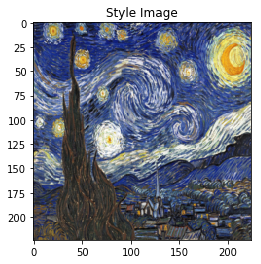

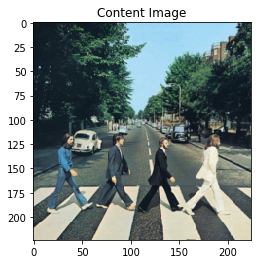

In [ ]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_img, title='Style Image')

plt.figure()
display(content_img, title='Content Image')


___

### Configure loss function
Create a classes for the style and content loss

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class



In [ ]:
def gram_matrix(input):
    # b = batch size (i.e., 1)
    # f = number of feature maps
    # (h,w) = dimensions of a f. map (N=c*d) 
    b, f, h, w = input.size() 

    # resize the input so we can get the gram matrix
    features = input.view(b * f, h * w)
    
    # calculate the ortho-normal basis
    basis = torch.mm(features, features.t())

    # 'normalize' by dividing by the number of elements in each feature map
    gram = basis.div(b * f * h * w)
    
    return gram

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        # Note: target_feature is a tensor
        super(StyleLoss, self).__init__()
        
        # detach to endsure we don't back prop into our gram matrix
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        
        # mean squared error between the gram matricies of our style image and the input image
        self.loss = F.mse_loss(G, self.target)

#         return input
        return self.loss

    
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()

        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
#         return input
        return self.loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


In [ ]:
# TEST HERE
# style_layer_vgg1 = VGGIntermediate(requested=style_layers_default)
# style_layer_activs1 = style_layer_vgg1(style_img)
# style_activ_1 = style_layer_activs1[0]
# style_loss1 = StyleLoss(target_feature=style_activ_1)
# input_activ_1 = style_layer_vgg1(input_img)[0]
# loss1 = style_loss1(input_activ_1)
# print(loss1)

___

### Training
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!




In [ ]:
# Start with a copy of the content image

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
# Show the image

In [ ]:
def get_style_model_and_losses(vgg,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    # deep copy before butchering
    vgg = copy.deepcopy(vgg)

    # normalization module
    normalization = Normalization().cuda()
    

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # vgg is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    
    model = nn.Sequential(normalization)
    
    for key in content_layer_activs.keys():
      target = content_layer_activs[key]
      content_loss = ContentLoss(target=target)
      content_losses.append(content_loss)
    
    for key in style_layer_activs.keys():
      target = style_layer_activs[key]
      style_loss = StyleLoss(target_feature=target)
      style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    j = 0
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:(j + 1)]
    
    return model, style_losses, content_losses

In [ ]:
import copy
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).cuda()

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()],lr=.1)
    return optimizer

def run_style_transfer(vgg,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(
        vgg, style_img, content_img
    )
    
    print("Get the optimizer..")
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image to be between 0 and 1
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
#             model(input_img)

            current_style_tensors = style_layer_vgg(input_img)
            current_content_tensors = content_layer_vgg(input_img)
    
            style_score = 0
            content_score = 0
        
            # Recall the objects returned by VGGIntermediate.forware() are dict's
            for i, key in enumerate(content_layers_default):
                loss = (ContentLoss((content_layer_vgg(content_img)[key])))(content_layer_vgg(input_img)[key])
                content_score += loss
                
#             for cl in content_losses:
#                 content_score += cl.loss
            for i, key in enumerate(current_style_tensors.keys()):
                loss = (StyleLoss((style_layer_vgg(style_img)[key])))(style_layer_vgg(input_img)[key])
                style_score += loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("epoch {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(models.vgg16(pretrained=True).features.cuda().eval(),
                            content_img, style_img, input_img)

Building the style transfer model..
Get the optimizer..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch 50:
Style Loss : 19.833862 Content Loss: 54.799576

epoch 100:
Style Loss : 7.293249 Content Loss: 30.884886

epoch 150:
Style Loss : 5.752522 Content Loss: 25.717918

epoch 200:
Style Loss : 5.089412 Content Loss: 23.282505

epoch 250:
Style Loss : 4.717170 Content Loss: 21.817913

epoch 300:
Style Loss : 4.685038 Content Loss: 20.862379



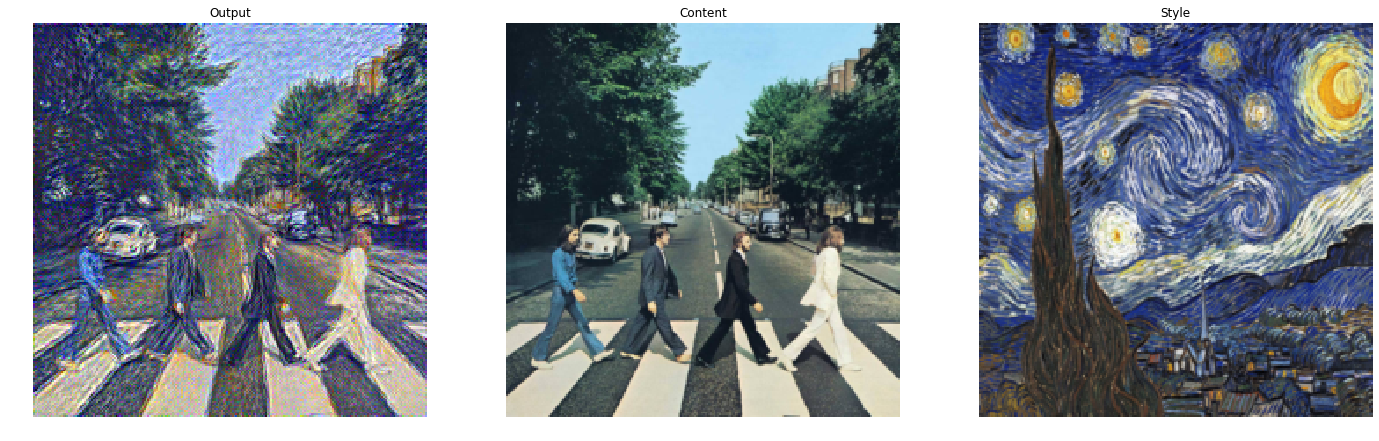

In [ ]:
def imshow(tensors, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image    
    num = len(tensors)
    f, axs = plt.subplots(1,num, figsize=(8*num, 8))
    
    for i in range(len(tensors)):
        image = tensors[i].cpu().clone()  # we clone the tensor to not make changes to the original
        image = image.squeeze(0)          # remove the batch dimension
        image = unloader(image)           # transform the image from a tensor to a PIL image so we can show it.

        p = plt.subplot(1,num,i+1)
        p.imshow(image)
        p.axis('off')
        
        if title is not None:             # Display the title if there is one.
            plt.title(title[i])         

    plt.show()
    plt.pause(0.001)                  # pause a bit so that plots are updated

imshow([output, content_img, style_img] , title=['Output','Content', 'Style'])